# Web Scraping Real Estate Data

In [1]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
plt.rcParams["axes.labelsize"] = 20
import warnings
import requests
import os
from dotenv import load_dotenv

warnings.filterwarnings('ignore')
%matplotlib inline 

load_dotenv()

# driver = webdriver.Chrome(ChromeDriverManager().install())

True

In [2]:
def get_pages(url, params):
    response = requests.request("GET", url, params=params)

    content = response.text
    soup = BeautifulSoup(content, features="html.parser")
    
    pages = soup.findAll("a", attrs={"class": "item"})
    page_nums = []
    for page in pages:
        try:
            page_nums.append(int(page.text))
        except ValueError:
            pass
    return page_nums

In [3]:
def generate__dataframe(city):
    prices = []
    beds = []
    baths = []
    sizes = []
    addresses = []
    # driver.get('https://www.realtor.com/realestateandhomes-search/New-York_NY')


    # city = "Texas"
    csv_file = f"{city.lower()}_listings.csv"
    if os.path.exists(csv_file):
        df = pd.read_csv(csv_file)
    else:
        url = "https://api.webscrapingapi.com/v1"
        uri = f"https://www.realtor.com/realestateandhomes-search/{city}"
        params = {
         "api_key": os.environ.get("API_KEY"),
         "url": uri
        }
        pages = get_pages(url, params)
        for page in range(1, pages[-1] + 1):
            if page == 1:
                params["url"] = uri
            else:
                params["url"] = f"{uri}/pg-{page}"
            response = requests.request("GET", url, params=params)

            content = response.text
            # print(content)
            soup = BeautifulSoup(content, features="html.parser")

            for element in soup.findAll("li", attrs={"class": "component_property-card"}):
                price = element.find("span", attrs={"data-label": "pc-price"})
                bed = element.find("li", attrs={"data-label": "pc-meta-beds"})
                bath = element.find("li", attrs={"data-label": "pc-meta-baths"})
                size = element.find("li", attrs={"data-label": "pc-meta-sqft"})
                address = element.find("div", attrs={"data-label": "pc-address"})

                if bed and bath:
                    nr_beds = bed.find("span", attrs={"data-label": "meta-value"})
                    nr_baths = bath.find("span", attrs={"data-label": "meta-value"})

                    # if nr_beds and float(nr_beds.text) >= 2 and nr_baths and float(nr_baths.text) >= 1
                    if nr_beds and nr_baths:
                        beds.append(nr_beds.text)
                        baths.append(nr_baths.text)

                        if price and price.text:
                            prices.append(price.text)
                        else:
                            prices.append("No display data")

                        if size and size.text:
                            sizes.append(size.text)
                        else:
                            sizes.append("No display data")
                        if address and address.text:
                            addresses.append(address.text)
                        else:
                            addresses.append("No display data")

        df = pd.DataFrame({'Address': addresses, 'Price': prices, 'Beds': beds, 'Baths': baths, 'Sizes': sizes})
        df.to_csv(f'{city.lower()}_listings.csv', index=False, encoding='utf-8')
    
    return df

In [4]:
df = generate__dataframe("Georgia")
df

,Address,Price,Beds,Baths,Sizes
0,"6474 Old Axson Rd, Douglas, GA 31535","$115,000",3,1.5,"1,384sqft"
1,"5956 Highway 32 E, Hortense, GA 31543","$72,900",3,1,"1,132sqft"
2,"310 W 4th St, Donalsonville, GA 39845","$120,000",3,2,"2,300sqft"
3,"146 Woodstone Cir, Leesburg, GA 31701","$155,000",3,2,"1,364sqft"
4,"471 Johnson Ct Unit G, Kathleen, GA 31047","$110,000",3,1,960sqft
...,...,...,...,...,...
8216,"208 Embry Blvd, Pendergrass, GA 30567","$335,490",5,3,No display data
8217,"632 Samantha Brooke Way, Bonaire, GA 31005","$335,900",5,3,"2,832sqft"
8218,"201 River Club Dr, Lagrange, GA 30240","$468,999",4,3.5,"2,735sqft"
8219,"Lot 15 Durham Estates Dr Lot 15, Sharpsburg, G...","$572,837",5,4,"3,662sqft"


In [5]:
def remove_sub_string(string, sub):
    if string == "No display data":
        string = 0
    if string == "Contact For Price":
        string = 0
    if isinstance(string, (int, float)):
        return string
    return string.replace(sub, "")

In [6]:
df["Price"] = df["Price"].apply(remove_sub_string, args=("From",))
df["Price"] = df["Price"].apply(remove_sub_string, args=("$",))
df["Price"] = df["Price"].apply(remove_sub_string, args=(",",))
df["Beds"] = df["Beds"].apply(remove_sub_string, args=("+",))
df["Baths"] = df["Baths"].apply(remove_sub_string, args=("+",))
df["Sizes"] = df["Sizes"].apply(remove_sub_string, args=(",",))
df["Sizes"] = df["Sizes"].apply(remove_sub_string, args=("sqft",))
df.head(10)

,Address,Price,Beds,Baths,Sizes
0,"6474 Old Axson Rd, Douglas, GA 31535",115000,3,1.5,1384
1,"5956 Highway 32 E, Hortense, GA 31543",72900,3,1,1132
2,"310 W 4th St, Donalsonville, GA 39845",120000,3,2,2300
3,"146 Woodstone Cir, Leesburg, GA 31701",155000,3,2,1364
4,"471 Johnson Ct Unit G, Kathleen, GA 31047",110000,3,1,960
5,"77 Mancey Garrason Loop NE, Ludowici, GA 31316",176000,3,2,1390
6,"4536 Nan Leah Ln, Columbus, GA 31909",192500,3,2,1558
7,"5629 Encino Ln, Valdosta, GA 31601",169900,3,2,1595
8,"17 Dogwood St, Hinesville, GA 31313",139900,3,2,1344
9,"1607 Meadow Pl, Valdosta, GA 31602",145900,4,2,1512


In [7]:
df = df.astype({"Price": int, "Beds": int, "Baths": float, "Sizes": int})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8221 entries, 0 to 8220
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Address  8221 non-null   object 
 1   Price    8221 non-null   int64  
 2   Beds     8221 non-null   int64  
 3   Baths    8221 non-null   float64
 4   Sizes    8221 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 321.3+ KB


In [8]:
df.head()

,Address,Price,Beds,Baths,Sizes
0,"6474 Old Axson Rd, Douglas, GA 31535",115000,3,1.5,1384
1,"5956 Highway 32 E, Hortense, GA 31543",72900,3,1.0,1132
2,"310 W 4th St, Donalsonville, GA 39845",120000,3,2.0,2300
3,"146 Woodstone Cir, Leesburg, GA 31701",155000,3,2.0,1364
4,"471 Johnson Ct Unit G, Kathleen, GA 31047",110000,3,1.0,960


In [9]:
df["Beds"].value_counts()

3     3353
4     2593
5     1154
2      784
6      173
1      116
7       30
8       12
10       2
9        2
26       1
25       1
Name: Beds, dtype: int64

In [10]:
bed_count_df = df["Beds"].value_counts()
bed_count_df = pd.DataFrame(bed_count_df)
bed_count_df.reset_index(inplace=True)
bed_count_df = bed_count_df.rename(columns = {'index':'beds', 'Beds': 'count'})
bed_count_df

,beds,count
0,3,3353
1,4,2593
2,5,1154
3,2,784
4,6,173
5,1,116
6,7,30
7,8,12
8,10,2
9,9,2


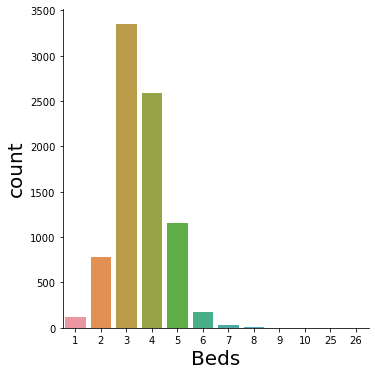

In [11]:
sns.catplot(x="Beds", kind="count", data=df)

In [12]:
df["Baths"].value_counts()

2.0     2582
2.5     1843
3.0     1310
3.5      904
1.0      577
4.0      337
4.5      241
1.5      232
5.5       86
5.0       64
6.5       16
7.5        8
6.0        6
8.0        4
0.5        4
8.5        3
9.5        1
18.0       1
7.0        1
24.0       1
Name: Baths, dtype: int64

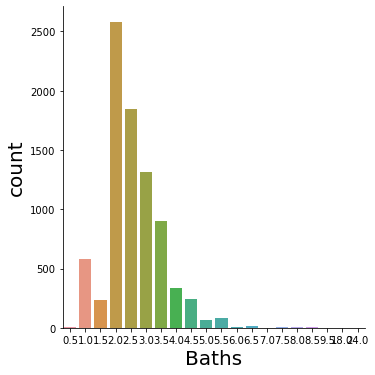

In [13]:
sns.catplot(x="Baths", kind="count", data=df)

In [14]:
df.describe()

,Price,Beds,Baths,Sizes
count,8.221000e+03,8221.000000,8221.000000,8221.000000
mean,3.960282e+05,3.566233,2.595061,1989.294855
std,3.759801e+05,1.066019,0.972584,1785.993853
min,0.000000e+00,1.000000,0.500000,0.000000
25%,2.400000e+05,3.000000,2.000000,1300.000000
50%,3.357000e+05,3.000000,2.500000,1892.000000
75%,4.450000e+05,4.000000,3.000000,2612.000000
max,9.800000e+06,26.000000,24.000000,82740.000000


In [15]:
bath_df = df[df["Baths"] <= 10]

In [16]:
bath_df

,Address,Price,Beds,Baths,Sizes
0,"6474 Old Axson Rd, Douglas, GA 31535",115000,3,1.5,1384
1,"5956 Highway 32 E, Hortense, GA 31543",72900,3,1.0,1132
2,"310 W 4th St, Donalsonville, GA 39845",120000,3,2.0,2300
3,"146 Woodstone Cir, Leesburg, GA 31701",155000,3,2.0,1364
4,"471 Johnson Ct Unit G, Kathleen, GA 31047",110000,3,1.0,960
...,...,...,...,...,...
8216,"208 Embry Blvd, Pendergrass, GA 30567",335490,5,3.0,0
8217,"632 Samantha Brooke Way, Bonaire, GA 31005",335900,5,3.0,2832
8218,"201 River Club Dr, Lagrange, GA 30240",468999,4,3.5,2735
8219,"Lot 15 Durham Estates Dr Lot 15, Sharpsburg, G...",572837,5,4.0,3662


In [17]:
df.groupby("Beds")["Price"].mean()

Beds
1     2.556068e+05
2     3.003592e+05
3     3.241306e+05
4     4.086817e+05
5     5.450989e+05
6     8.812598e+05
7     1.288973e+06
8     1.659108e+06
9     7.324500e+05
10    6.069000e+05
25    3.950000e+05
26    9.400000e+05
Name: Price, dtype: float64

In [18]:
bp_df = df.groupby("Beds")["Price"].mean()
bp_df = pd.DataFrame(bp_df)
bp_df.reset_index(inplace=True)
bp_df.rename(columns={"Price": "avg_price"}, inplace=True)
bp_df = bp_df[bp_df["Beds"] <= 10]
bp_df

,Beds,avg_price
0,1,2.556068e+05
1,2,3.003592e+05
2,3,3.241306e+05
3,4,4.086817e+05
4,5,5.450989e+05
5,6,8.812598e+05
6,7,1.288973e+06
7,8,1.659108e+06
8,9,7.324500e+05
9,10,6.069000e+05


In [19]:
btp_df = df.groupby("Baths")["Price"].mean()
btp_df = pd.DataFrame(btp_df)
btp_df.reset_index(inplace=True)
btp_df.rename(columns={"Price": "avg_price"}, inplace=True)
btp_df = btp_df[btp_df["Baths"] <= 10]
btp_df

,Baths,avg_price
0,0.5,2.947250e+05
1,1.0,1.842152e+05
2,1.5,2.136518e+05
3,2.0,2.780577e+05
4,2.5,3.676470e+05
5,3.0,4.022579e+05
6,3.5,5.808028e+05
7,4.0,5.651849e+05
8,4.5,8.055602e+05
9,5.0,7.767281e+05
